<a href="https://colab.research.google.com/github/victorcharpentier/Anapix/blob/main/VPC_Global_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMDhiZDBkMC1jMjhkLTQ0YjgtYmVlYS02Y2E0ZThmNDY3NjIifQ=="

!pip install pytorch-lightning

import psutil
import ipywidgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler, SGD

import os

import albumentations as A
from albumentations.pytorch import ToTensor #ToTensorV2, ToTensor

from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning import loggers
from pytorch_lightning.metrics.functional import accuracy, auroc, recall, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from collections import OrderedDict
from sklearn import manifold
from pandas import DataFrame
from copy import deepcopy

import sklearn as sk
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import AgglomerativeClustering

     |████████████████████████████████| 819kB 5.1MB/s 
     |████████████████████████████████| 122kB 39.7MB/s 
     |████████████████████████████████| 829kB 30.4MB/s 
     |████████████████████████████████| 10.6MB 35.1MB/s 
     |████████████████████████████████| 645kB 29.9MB/s 
     |████████████████████████████████| 235kB 40.3MB/s 
     |████████████████████████████████| 1.3MB 31.5MB/s 
     |████████████████████████████████| 143kB 38.9MB/s 
     |████████████████████████████████| 296kB 38.7MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=5a3e63fc43b4f79059a27e63b8b506f0efad66703d1612fbc73e857c2547fcc3
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My Drive/Anapix/

/content/gdrive/My Drive/Anapix


In [ ]:
images_path = 'vpc_autocropped_224/'

No handles with labels found to put in legend.


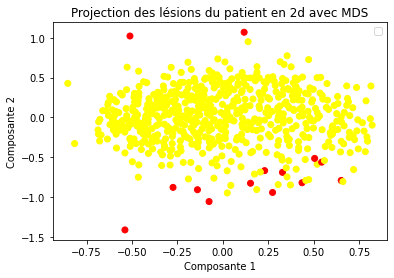

No handles with labels found to put in legend.


63
Le clustering unique trouve 4 unique dont 3 sur 14 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 10 VPC sur 14 dont 89 faux positifs
la liste des clusters est : [[1, 2, 3, 4, 5, 10, 12, 15, 18, 56, 57, 61, 64, 68, 71, 92, 105, 133, 136, 137, 149, 155], [311, 386, 388, 412, 451, 536, 556, 558, 573, 578], [35, 134, 390, 594], [70, 76, 135, 139, 148, 159, 183, 257, 273, 453, 477], [74, 83, 84, 85, 91, 93, 95, 97, 98, 103, 116, 121, 122, 126, 130, 131, 419, 421, 434, 491, 508], [410, 560], [43, 46, 51, 79], [151, 411, 462, 480, 493, 548, 577, 582], [14, 161, 192, 195, 292, 464], [23, 25, 26, 114, 196, 199, 200, 201, 202, 213, 215, 240, 246, 251, 264, 344, 345, 346, 348, 349, 350, 352, 353, 368, 500, 504, 505], [16, 123, 154, 168, 190, 209, 210, 214, 216, 222, 223, 225, 226, 227, 228, 233, 236, 256, 261, 267, 269, 274, 275, 286, 335, 337, 358, 369, 374, 376, 378, 379, 381, 382, 383, 384, 385, 472, 588, 589], [351, 456], [20, 30, 65, 141, 158, 167, 206, 270, 298, 3

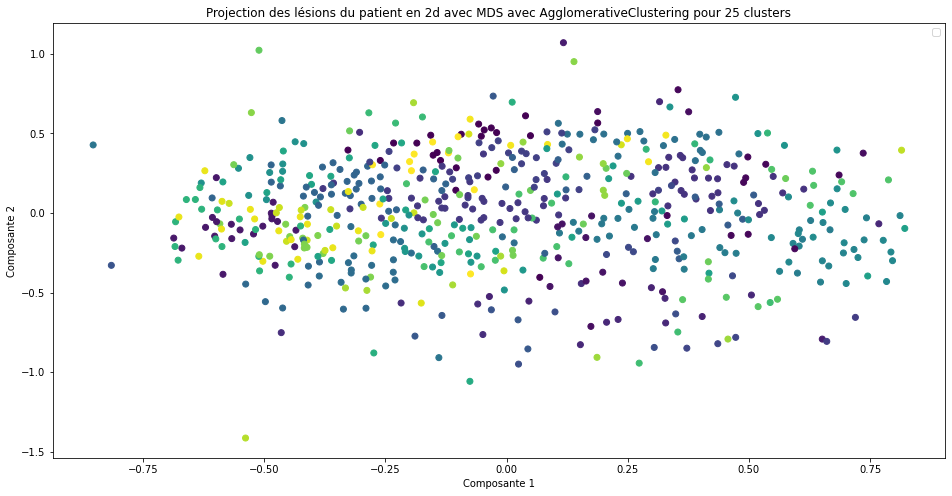

Pour les clusters uniques, rappel : 21.428571428571427 % précision : 75.0 % et f1 = 33.33333333333333
Pour les clusters uniques + petit cluster , rappel : 71.42857142857143 % précision : 10.1010101010101 % et f1 = 17.699115044247787
Pour les clusters uniques + petit cluster , spécificité : 84.70790378006873 % 


In [ ]:
nb_VPC_identifiés_par_cluster_unique=0
nb_VPC_identifiés_par_cluster_unique_et_petit_cluster=0
nb_VPC_total=0 #nombre de lésions prédites comme des VPC dans un cluster unique ou dans des petits clusters
nb_faux_VPC_unique=0
nb_faux_VPC_petit_cluster=0
nb_images=0 #nombres d'images dans notre dataset
nb_testés_total=0 #initialisation des données statistiques

patients_train_clustering_par_predicteurs=pd.read_csv('patients_train_clustering_par_predicteurs.csv') #on lit notre dataset d'entrainement
patients_train_clustering_par_predicteurs.set_index('patient_id',inplace=True) #et on l'index par l'identifiant du patient

Y = DataFrame(patients_train_clustering_par_predicteurs['concensus'], columns = ['concensus']) #on récupère le label de l'image pour faire de la visualisation
X = patients_train_clustering_par_predicteurs.drop(['image','concensus'],axis=1) #on récupère les features de notre images
Y['concensus'][Y['concensus'] == 0] = "red"
Y['concensus'][Y['concensus'] != "red"] = "yellow"
y=[]
for i ,row in Y.iterrows():
  y.append(row[0])  #on créer une liste de couleur ou la couleur rouge décrit les VPC et le jaune les autres 

nb_images=nb_images+len(y)

silhouette_vals=[]
    
nb_cluster_minimum=40
K = range(nb_cluster_minimum,70) #test de nb_cluster_minimum à 5 clusters
for o in K:
  clustering = AgglomerativeClustering(n_clusters=o).fit(X)
  labels = clustering.labels_
  silhouette_vals.append(np.mean(silhouette_score(X,labels))) #pour un certains nombre de clusters on calcule la silhouette de notre clustering

mds = manifold.MDS(n_components=2)
mds.fit(X)
projectedMDS = mds.fit_transform(X)
plt.scatter(projectedMDS[:, 0], projectedMDS[:, 1], c=y)
plt.title("Projection des lésions du patient en 2d avec MDS")
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.legend()
plt.show() #on visualise les lésions cutanées du patient avec mds, les VPC y sont situés en rouge 

idx_max=0
max=-1
for k in range(len(silhouette_vals)): #on retrouve le nombre de clusters maximisant la silhouette - nb_cluster_minimum
  if silhouette_vals[k]>max:
    max=silhouette_vals[k]
    idx_max=k

print(idx_max+nb_cluster_minimum)
clustering = AgglomerativeClustering(n_clusters=idx_max+nb_cluster_minimum)    #l'on utilise le nombre de clusters maximisant la silhouette
prediction = clustering.fit_predict(X)

    #comparaison entre le vrai clustering et la prediction au niveau des VPC
    #premièrement on regarde le nombre de VPC repérés dans des clusters uniques

index_VPC=[] #dans cette liste apparaitront les index des VPC
nb_testés=0 #nombre de lésions prédites comme des VPC dans un cluster unique
nb_clusters=len(np.unique(prediction)) #nombre de clusters dans la prediction

liste_clusters=[] #dans cette liste apparaitront les index des images par cluster pour les repérer plus facilement an allant regarder nos images
for e in range(nb_clusters):
  liste_clusters.append([])

for a in range(len(y)):
  if y[a]=="red":
    index_VPC.append(a) #index des VPC
  liste_clusters[prediction[a]].append(a)
    
clusters_unique=[]
for g in range (nb_clusters):
  if len(liste_clusters[g])==1:
    nb_testés=nb_testés+1
    nb_testés_total=nb_testés_total+1
    clusters_unique.append(liste_clusters[g][0]) #on récupère les index de clusters uniques
    
nb_trouvés_unique=0
for l in index_VPC:
  if l in clusters_unique:
    nb_trouvés_unique=nb_trouvés_unique+1 #on comptabilise les clusters uniques étant réellement des VPC 
    
nb_VPC_identifiés_par_cluster_unique=nb_VPC_identifiés_par_cluster_unique + nb_trouvés_unique #nombre total de VPC trouvés par clusters contenant un seul individu
nb_faux_VPC_unique=nb_faux_VPC_unique+len(clusters_unique)-nb_trouvés_unique #nombres total d'images apparaissant dans des clusters uniques sans être un VPC
  
print("Le clustering unique trouve "+str(len(clusters_unique))+ " unique dont "+str(nb_trouvés_unique)+" sur "+str(len(index_VPC))+ " VPC et " + str(len(clusters_unique)-nb_trouvés_unique)+ " faux positifs")

#dans un second temps on identifie les clusters possédant moins de x d'individus et on regarde le nombre de VPC à l'intérieur

nb_VPC_total = nb_VPC_total + len(index_VPC)

nb_trouvés_petit_cluster=0
nb_cas_petit_cluster=0 #le nombre d'images que l'on va tester en regardant les petit clusters
liste_index_petit_clusters=[]
nb_individus_max=6

for r in range(len(liste_clusters)):
  if 1<len(liste_clusters[r])<=nb_individus_max: #pour les clusters allant jusqu'à nb_individus_max individus on regarde s'il s'y trouve des VPC
    nb_cas_petit_cluster=nb_cas_petit_cluster+len(liste_clusters[r]) 
    nb_testés=nb_testés+len(liste_clusters[r]) #le nombre d'images testés augmente et permet de voir les nombre de faux positifs pour un patient
    nb_testés_total=nb_testés_total+len(liste_clusters[r])
    liste_index_petit_clusters.append(r) #on rajoute tout les petits clusters dans une liste
    
for g in liste_index_petit_clusters:
  for h in liste_clusters[g]:
    if h in index_VPC:          #on regarde s'il y a des VPC dans les petits clusters
      nb_trouvés_petit_cluster=nb_trouvés_petit_cluster+1

nb_faux_VPC_petit_cluster = nb_faux_VPC_petit_cluster + nb_cas_petit_cluster - nb_trouvés_petit_cluster #le nombre de faux positifs trouvés dans les petits clusters se voit augmenter 
nb_VPC_identifiés_par_cluster_unique_et_petit_cluster = nb_VPC_identifiés_par_cluster_unique_et_petit_cluster + nb_trouvés_unique +nb_trouvés_petit_cluster #le nombre de vrai positif dans les clusters uniques et petits clusters

print("Le clustering unique et petits clusters trouve "+str(nb_trouvés_unique+nb_trouvés_petit_cluster)+" VPC sur "+str(len(index_VPC))+ " dont " + str(nb_testés-nb_trouvés_unique-nb_trouvés_petit_cluster)+ " faux positifs")

print("la liste des clusters est : "+str(liste_clusters))
print("les index des VPC sont : "+str(index_VPC))

plt.figure(figsize=(16,8))
plt.scatter(projectedMDS[: , 0] , projectedMDS[: , 1] , c = prediction)
plt.title("Projection des lésions du patient en 2d avec MDS avec AgglomerativeClustering pour "+str(idx_max+2)+" clusters")
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.legend()
plt.show() #cette fois on affiche la prediction du clustering jierarchique ayant le meilleur score en silhouette 

  
rappel_cluster_unique=(nb_VPC_identifiés_par_cluster_unique/nb_VPC_total)*100
precision_cluster_unique=((nb_VPC_identifiés_par_cluster_unique)/(nb_faux_VPC_unique+nb_VPC_identifiés_par_cluster_unique))*100 #définition des scores
f1_cluster_unique=2*(rappel_cluster_unique*precision_cluster_unique)/(rappel_cluster_unique+precision_cluster_unique)

rappel_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/nb_VPC_total)*100
precision_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/(nb_faux_VPC_unique+nb_faux_VPC_petit_cluster+nb_VPC_identifiés_par_cluster_unique_et_petit_cluster))*100
f1__unique_petit_cluster=2*(rappel_unique_petit_cluster*precision_unique_petit_cluster)/(rappel_unique_petit_cluster+precision_unique_petit_cluster)

fp=nb_testés_total-nb_VPC_identifiés_par_cluster_unique_et_petit_cluster
vp=nb_VPC_identifiés_par_cluster_unique_et_petit_cluster
fn = nb_VPC_total- vp
vn= nb_images -fp-vp-fn

print("Pour les clusters uniques, rappel : "+ str(rappel_cluster_unique) + " % précision : "+str(precision_cluster_unique) + " % et f1 = "+str(f1_cluster_unique))
print("Pour les clusters uniques + petit cluster , rappel : "+ str(rappel_unique_petit_cluster) + " % précision : "+str(precision_unique_petit_cluster) + " % et f1 = "+str(f1__unique_petit_cluster))
print("Pour les clusters uniques + petit cluster , spécificité : "+ str((vn)*100/(vn+fp))+ " % ")